Mit diesem Script kann die Verschiebung derSatellitenbilder visualisiert werden. 

In [1]:
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [8]:
# Same function as in phenometrics script. Only the stack is used here
def load_ndvi_stack(directory, sentinel, filter_threshold=None):
    """
    Load NDVI stack from a directory containing NDVI images.
    A two dimensional mask is returned that is true for all pixels that hold at least one.
    directory: str - path to the directory containing the NDVI images
    sentinel: bool - whether the images are from Sentinel or not (the array needs to be flipped vertically for Planet images)
    filter_threshold: int - if not None, only images with DOY >= filter_threshold are loaded
    """
    print('Loading NDVI stack from', directory)
    print('The width of the plots are limited to the given chunk size. The total width of all plots together may be less than end_px - start_px, since only valid (unmasked) pixels are plotted.')
    # TODO: shouldn't the first dataset below the threshold be taken into consideration?

    file_paths = sorted([os.path.join(directory, fp) for fp in os.listdir(directory) if fp.endswith('.tif')])

    def sort_by_doy(file_paths):
        fps = np.array(file_paths)
        fp_doys = np.array([os.path.basename(fp).split('_')[-2].split('.')[0] for fp in fps])
        sorted_indices = np.argsort(fp_doys)
        return fps[sorted_indices]
    
    file_paths = sort_by_doy(file_paths)

    doys = np.array([int(os.path.basename(fp).split('_')[-2].split('.')[0]) for fp in file_paths], dtype=np.int64)
    
    if filter_threshold is not None:
        file_paths = [fp for fp in file_paths if int(os.path.basename(fp).split('_')[-2].split('.')[0]) >= filter_threshold]
        doys = np.array([int(os.path.basename(fp).split('_')[-2].split('.')[0]) for fp in file_paths], dtype=np.int64)
          
    ndvi_stack = []
    mask_stack = []
       
    for fp in file_paths:
        with rasterio.open(fp) as dataset:
            ndvi_data = dataset.read(1).astype(np.float64)
            # ndvi_stack.append(ndvi_data[:300, :300])
            ndvi_stack.append(ndvi_data)   
            mask_stack.append(np.isnan(ndvi_data))

    ndvi_stack = np.array(ndvi_stack)
    mask_stack = np.array(mask_stack)

    if len(doys) < 3:
        raise ValueError(f'Not enough images in the stack (less than 3!) in directory {directory} with threshold {filter_threshold}')

    if not sentinel:
        ndvi_stack = np.flip(ndvi_stack, axis=1)
        mask_stack = np.flip(mask_stack, axis=1)

    valid_image_area_mask = ~np.any(mask_stack, axis=0)
    return ndvi_stack, valid_image_area_mask, doys


In [3]:
def create_slice_from_stack(stack, mask, horizontal, index, start_px, end_px):
    """
    Create a slice from a stack of images. 
    If horizontal is True, the slice is taken horizontally from the stack.
    If horizontal is False, the slice is taken vertically from the stack.
    """
    if horizontal:
        slice = stack[:, index, start_px:end_px]
        slice_mask = mask[index, start_px:end_px]

    else:
        slice = stack[:, start_px:end_px, index]
        slice_mask = mask[start_px:end_px, index]
    return slice[:, slice_mask]

In [4]:
def plot_ndvi(ndvi_hor_cleaned, horizontal, index, start_px, end_px, doys):
    # Colormap from white over yellow to green
    cdict = {
        'green':[(0.0, 1.0, 1.0),
                (0.5, 1.0, 1.0),
                (1.0, 0.2, 0.3)],

        'red': [(0.0, 1.0, 1.0),
                (0.25, 1.0, 1.0),
                (0.75, 0.0, 0.0),
                (1.0,  0.1, 0.1)],

        'blue': [(0.0, 1.0, 1.0),
                (0.5, 0.0, 0.0),
                (1.0, 0.0,0.0)]
                }

    cmap2 = LinearSegmentedColormap('white_to_green', cdict, N=100, gamma=1.0)
    cmap2.set_bad(color='magenta')

    # Create the figure and axis with increased size
    fig, ax = plt.subplots(figsize=(16, 8))

    # Plot the image with the custom colormap, using `nan_to_num` to ensure NaNs are recognized
    cax = ax.imshow(np.ma.masked_invalid(ndvi_hor_cleaned), aspect='auto', cmap=cmap2)

    # Invert the y-axis
    ax.invert_yaxis()

    # Set the y-axis ticks and labels to the DOY values
    ax.set_yticks(np.arange(len(doys)))
    ax.set_yticklabels(doys)

    # Add labels to the axes
    ax.set_ylabel('Day of Year (DOY)')
    ax.set_xlabel('Pixel Position')

    # Add a color bar to the plot
    if horizontal:
        title = f'NDVI Values over time for horizontal image slice at row {index}, column {start_px} to {end_px}'
    else:
        title = f'NDVI Values over time for vertical image slice column {index}, row {start_px} to {end_px}'

    plt.title(title)
    cbar = fig.colorbar(cax, ax=ax, orientation='vertical')
    cbar.set_label('NDVI Value')

    plt.show()


In [12]:
def run_plotting(stack_path, horizontal, line_or_row_number, sentinel, chunk_size=200, start_px=0, end_px=200):
    """
    This function starts the plotting process. It loads the stack, creates a slice and plots the NDVI values.
    """
    stack, mask, doys = load_ndvi_stack(stack_path, sentinel)
    s = create_slice_from_stack(stack, mask, horizontal, line_or_row_number, start_px, end_px)

    i = 0
    while i < s.shape[1]:
        j = i + chunk_size
        arr = s[:, i:j]
        plot_ndvi(arr, horizontal, line_or_row_number, i, j, doys)
        i = j


<h1>Start here!</h1>
<p>Change the following variables as needed:</br>
    <p><h3>stack_path:</h3> string, the path to the directory containing the NDVI images. It can be an absolute or relative path.</br></p>
    <p><h3>horizontal:</h3> boolean, if True, the slice is taken horizontally from the stack/image. If False, the slice is taken vertically.</br></p>
    <p><h3>line_or_row_number:</h3> int, the index of the pixel row or column represented in the plots.</br></p>
    <p><h3>chunk_size:</h3> int, the width of the slice represented in one single plot. If this number is smaller than the width/height of the image, multiple plots are created.</br></p>
    <p><h3>start_px and end_px:</h3> int, select the pixels of the row or column to be plotted, starting at start_px and ending at end_px. The end_px may exceed the actual image width or height.</p>
    </p>


In [14]:
horizontal = False
sentinel = True
line_or_row_number = 0
chunk_size = 200
start_px = 0
end_px = 3000
stack_path = './S2/'

Loading NDVI stack from ./S2/
The width of the plots are limited to the given chunk size. The total width of all plots together may be less than end_px - start_px, since only valid (unmasked) pixels are plotted.


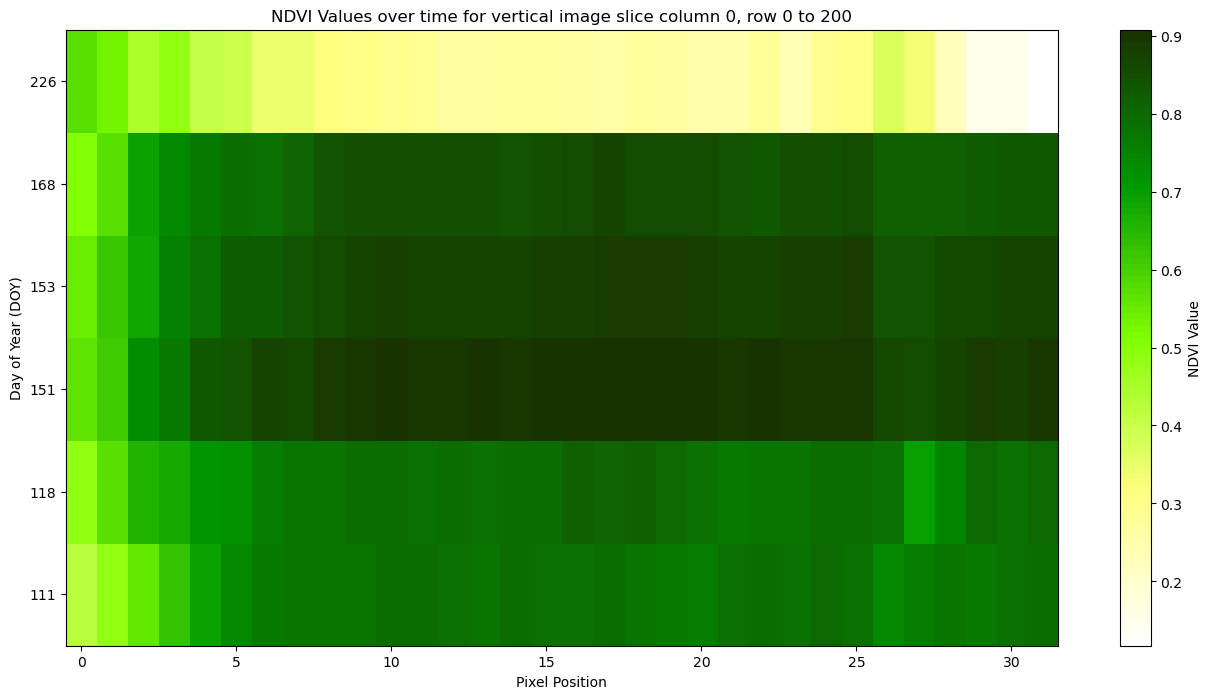

In [15]:
run_plotting(stack_path, horizontal, line_or_row_number, sentinel, chunk_size, start_px, end_px)

In [18]:
horizontal = False
sentinel = False
line_or_row_number = 5
chunk_size = 200
start_px = 0
end_px = 3000
stack_path = './PS/'

Loading NDVI stack from ./PS/
The width of the plots are limited to the given chunk size. The total width of all plots together may be less than end_px - start_px, since only valid (unmasked) pixels are plotted.


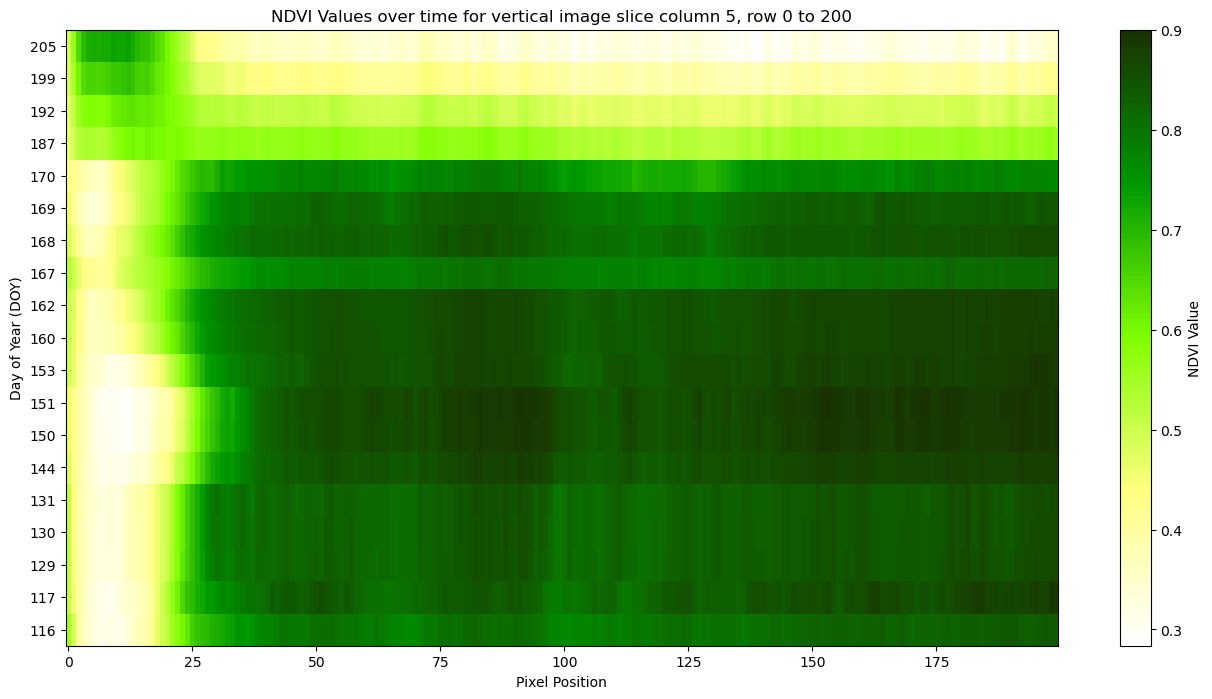

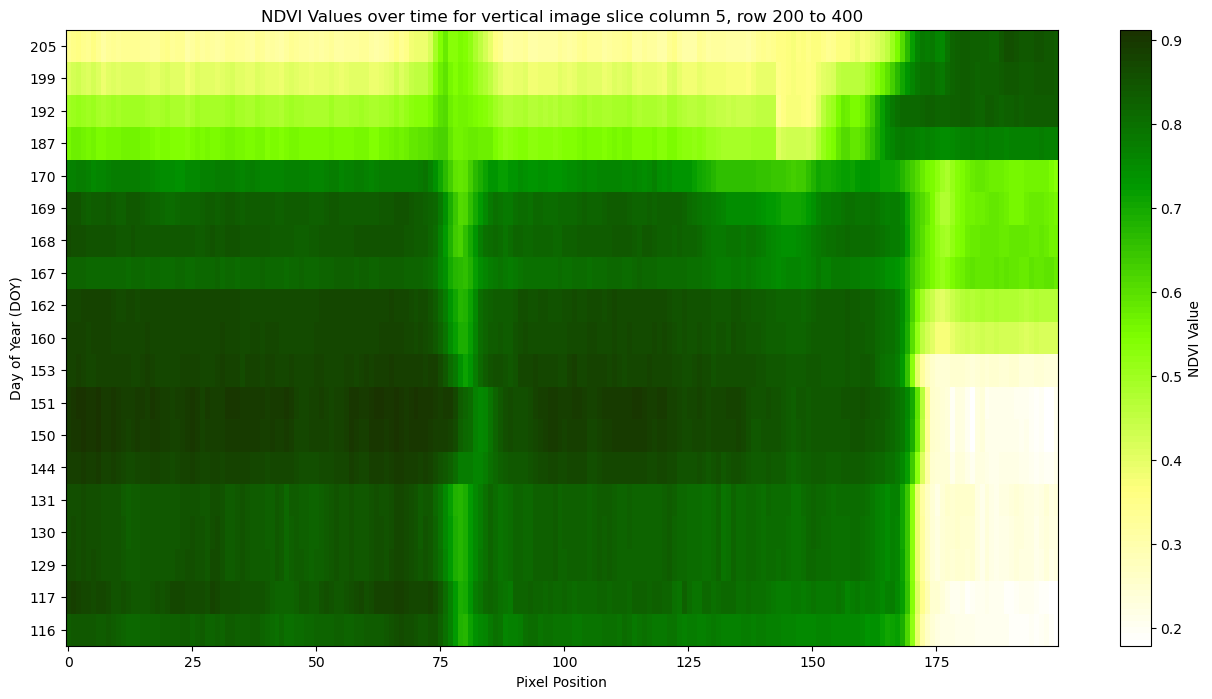

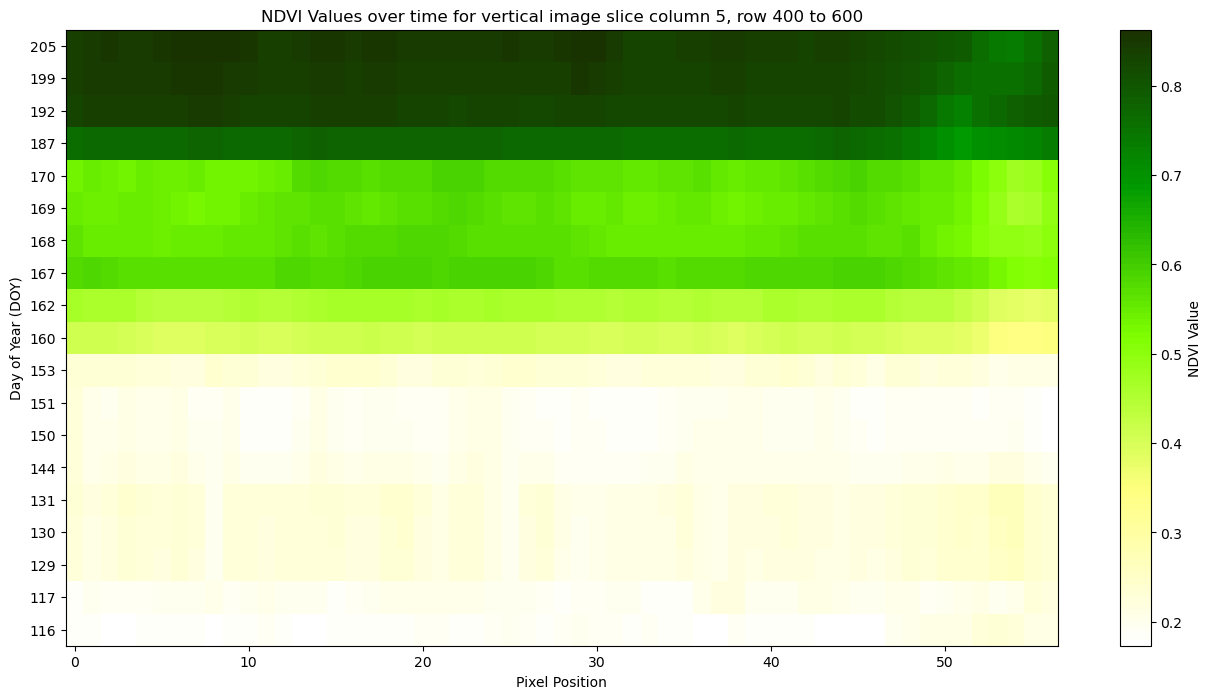

In [19]:
run_plotting(stack_path, horizontal, line_or_row_number, sentinel, chunk_size, start_px, end_px)